<a href="https://colab.research.google.com/github/SZ330/EE344-Assignment-5/blob/main/EE344_Assignment_5_DNN_Faults_student_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [5]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [41]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [42]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers (Linear, BatchNorm1d, Dropout, etc.)
        # self....
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        return self.net(x)

In [43]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_Reg4(INPUT_DIM, H1, H2, OUT_DIM, DROPOUT_P).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY
)

# model = DNN_Reg4(...).to(device)
# loss_fn = ...
# optimizer = ...


In [44]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer.zero_grad()
            # TODO: forward pass
            preds = model(xb)
            # TODO: compute loss
            loss = loss_fn(preds, yb)
            # TODO: backward
            loss.backward()
            # TODO: optimizer step
            optimizer.step()

            # total += loss.item() * xb.size(0)
            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            average_loss = total / n
            print(f"Epoch {ep:3d} | train MSE: {average_loss:.6f}")

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

# TODO: Train the model
train_part1(model, train_loader_1, epochs=EPOCHS)

Epoch   1 | train MSE: 1.083587
Epoch 500 | train MSE: 0.096063
Epoch 1000 | train MSE: 0.097979


In [45]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8598    0.8023    0.8300      2377
           C     0.9976    0.9293    0.9623      2263
           B     0.9986    0.9352    0.9659      3057
           A     0.9614    0.9825    0.9718      3144

   micro avg     0.9573    0.9185    0.9375     10841
   macro avg     0.9544    0.9123    0.9325     10841
weighted avg     0.9572    0.9185    0.9371     10841
 samples avg     0.6681    0.6508    0.6550     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2814  311]
 [ 470 1907]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3234    5]
 [ 160 2103]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2441    4]
 [ 198 2859]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2234  124]
 [  55 3089]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8627    0.8018    0.8311      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

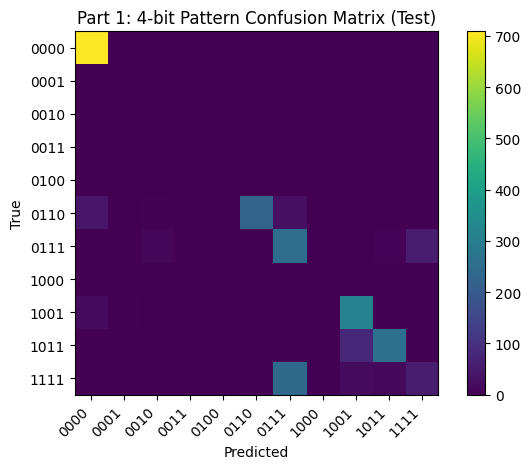

[[709   0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [ 42   0   3   0   1 226  29   0   0   0   0]
 [  1   0  10   0   0   4 253   0   0   7  54]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [ 20   3   0   0   0   0   0   1 315   0   0]
 [  1   1   0   0   0   0   0   0  78 260   0]
 [  0   0   0   1   0   4 244   0  22  15  54]]


In [37]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [12]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [46]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h2, out_dim)
        )

    def forward(self, x):
        # TODO: forward pass returning logits (N,4)
        return self.net(x)

In [57]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...
model2 = DNN_MultiLabel4(
    INPUT_DIM,
    H1,
    H2,
    OUT_DIM,
    DROPOUT_P
).to(device)

loss_fn2 = nn.BCEWithLogitsLoss()
optimizer2 = torch.optim.Adam(
    model2.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY
)


In [58]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer2.zero_grad()
            # TODO: logits = model(xb)
            logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            loss = loss_fn2(logits, yb)
            # TODO: backward + step
            loss.backward()
            optimizer2.step()
            # total += loss.item() * xb.size(0)
            total += loss.item() * xb.size(0)
            n += xb.size(0)
        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            average_loss2 = total / n
            print(f"Epoch {ep:3d} | train BCE loss: {average_loss2:.6f}")

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

train_part2(model2, train_loader_2, epochs=EPOCHS)


Epoch   1 | train BCE loss: 0.714742
Epoch 500 | train BCE loss: 0.712743
Epoch 1000 | train BCE loss: 0.712466


In [59]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8621    0.7943    0.8268      2377
           C     1.0000    0.9213    0.9591      2263
           B     0.9986    0.9395    0.9681      3057
           A     1.0000    0.9625    0.9809      3144

   micro avg     0.9699    0.9105    0.9393     10841
   macro avg     0.9652    0.9044    0.9337     10841
weighted avg     0.9694    0.9105    0.9389     10841
 samples avg     0.6693    0.6439    0.6517     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2823  302]
 [ 489 1888]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 178 2085]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2441    4]
 [ 185 2872]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2358    0]
 [ 118 3026]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8629    0.7841    0.8216      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

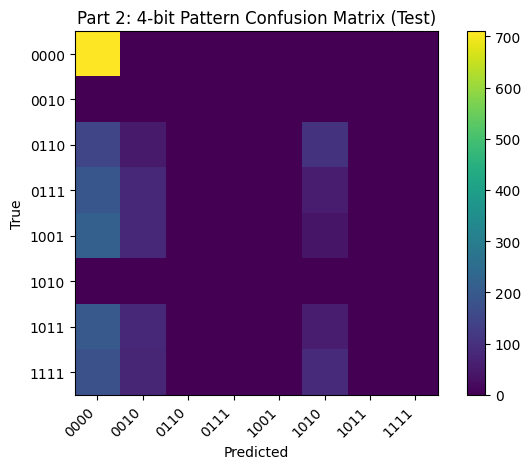

[[710   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [147  51   0   0   0 103   0   0]
 [190  82   0   0   0  57   0   0]
 [218  82   0   0   0  39   0   0]
 [  0   0   0   0   0   0   0   0]
 [199  83   0   0   0  58   0   0]
 [177  76   0   0   0  87   0   0]]


In [17]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [18]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [54]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h2, num_classes)
        )

    def forward(self, x):
        # TODO: forward pass returning logits (N,6)
        return self.net(x)


In [60]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
model3 = DNN_MultiClass6(
    INPUT_DIM,
    H1,
    H2,
    num_classes=6,
    p_drop=DROPOUT_P
).to(device)
# TODO: loss_fn = ...
loss_fn3 = nn.CrossEntropyLoss()
# TODO: optimizer = ...
optimizer3 = torch.optim.Adam(
    model3.parameters(),
    lr=LR,
    weight_decay=L2_WEIGHT_DECAY
)


In [61]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer3.zero_grad()
            # TODO: logits = model(xb)
            logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            loss = loss_fn3(logits, yb)
            # TODO: backward + step
            loss.backward()
            optimizer3.step()

            # total += loss.item() * xb.size(0)
            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            average_loss3 = total / n
            print(f"Epoch {ep:3d} | train CE loss: {average_loss3:.6f}")

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# TODO: Train the model
train_part3(model3, train_loader_3, epochs=EPOCHS)

Epoch   1 | train CE loss: 1.788187
Epoch 500 | train CE loss: 0.640829
Epoch 1000 | train CE loss: 0.617113



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9808    0.4326    0.6004      1655
          LG     0.0000    0.0000    0.0000       790
          LL     0.2403    0.9687    0.3851       703
         LLG     0.4355    0.9987    0.6065       794
         LLL     0.0000    0.0000    0.0000       767
        LLLG     0.0000    0.0000    0.0000       793

    accuracy                         0.3980      5502
   macro avg     0.2761    0.4000    0.2653      5502
weighted avg     0.3886    0.3980    0.3173      5502



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


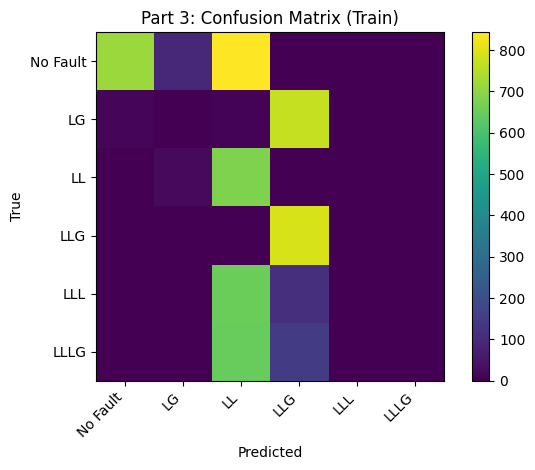


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9725    0.3986    0.5654       710
          LG     0.0000    0.0000    0.0000       339
          LL     0.2353    0.9834    0.3797       301
         LLG     0.4433    1.0000    0.6143       340
         LLL     0.0000    0.0000    0.0000       329
        LLLG     0.0000    0.0000    0.0000       340

    accuracy                         0.3896      2359
   macro avg     0.2752    0.3970    0.2599      2359
weighted avg     0.3866    0.3896    0.3072      2359



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


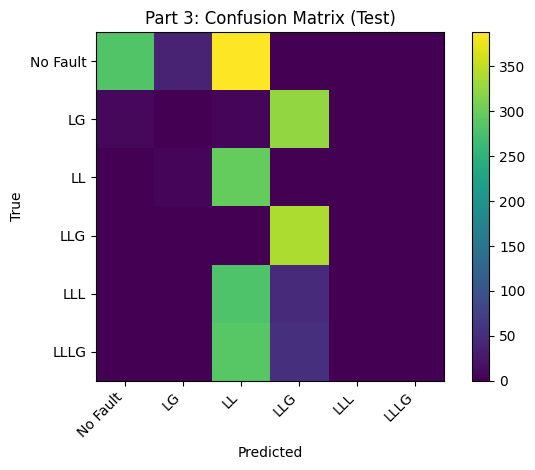

In [62]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- Q1:
- Q2:
- Q3:


## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


In [78]:
CSV_PATH = 'Industrial_fault_detection.csv'
df = pd.read_csv(CSV_PATH)

X = df.drop(columns=["Fault_Type"]).values
y_multiclass = df["Fault_Type"].values
y_binary = (y_multiclass != 0).astype(int)

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X,
    y_binary,
    test_size=0.30,
    stratify=y_binary,
    random_state=42
)

In [84]:
scaler_5 = RobustScaler()
X_train_s5 = scaler_5.fit_transform(X_train5).astype(np.float32)
X_test_s5  = scaler_5.transform(X_test5).astype(np.float32)

Xtr5 = torch.from_numpy(X_train_s5.astype("float32"))
Xte5 = torch.from_numpy(X_test_s5.astype("float32"))
Ytr5 = torch.from_numpy(y_train5.astype(np.float32)).view(-1, 1)
Yte5 = torch.from_numpy(y_test5.astype(np.float32)).view(-1, 1)

train_loader_5 = DataLoader(TensorDataset(Xtr5, Ytr5), batch_size=BATCH_SIZE, shuffle=True)

In [79]:
class DNN_Binary(nn.Module):
    def __init__(self, input_dim=36, h1=16, h2=8, p_drop=0.25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(h2, 1)
        )

    def forward(self, x):
        return self.net(x)

In [95]:
model5 = DNN_Binary(input_dim=36, h1=16, h2=8, p_drop=0.25).to(device)
loss_fn5 = nn.BCEWithLogitsLoss()
optimizer5 = torch.optim.Adam(
    model5.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
EPOCHS = 2000

In [93]:
# ----------------------------
# Training loop scaffold
# ----------------------------
def train_part5(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer5.zero_grad()
            logits = model(xb)
            loss = loss_fn5(logits, yb)
            loss.backward()
            optimizer5.step()
            total += loss.item() * xb.size(0)
            n += xb.size(0)

        if ep in [1, epochs//2, epochs]:
            average_loss3 = total / n
            print(f"Epoch {ep:3d} | train CE loss: {average_loss3:.6f}")

@torch.no_grad()
def predict_part5(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# TODO: Train the model
train_part5(model5, train_loader_5, epochs=EPOCHS)

Epoch   1 | train CE loss: 1.103158
Epoch 1000 | train CE loss: 0.493544
Epoch 2000 | train CE loss: 0.487745



=== Part 5 | Train ===
              precision    recall  f1-score   support

    No Fault     0.7243    1.0000    0.8401       507
       Fault     0.0000    0.0000    0.0000       193

    accuracy                         0.7243       700
   macro avg     0.3621    0.5000    0.4200       700
weighted avg     0.5246    0.7243    0.6085       700



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


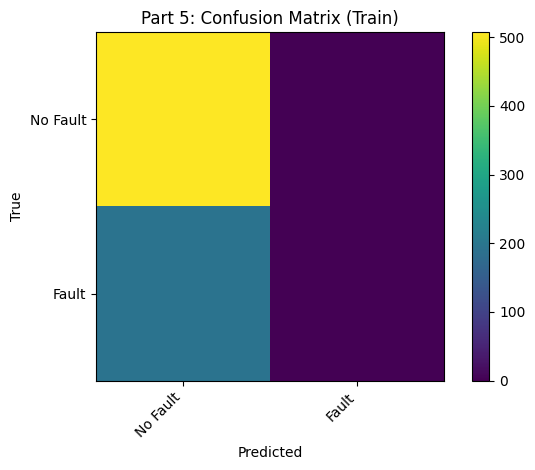


=== Part 5 | Test ===
              precision    recall  f1-score   support

    No Fault     0.7267    1.0000    0.8417       218
       Fault     0.0000    0.0000    0.0000        82

    accuracy                         0.7267       300
   macro avg     0.3633    0.5000    0.4208       300
weighted avg     0.5280    0.7267    0.6116       300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


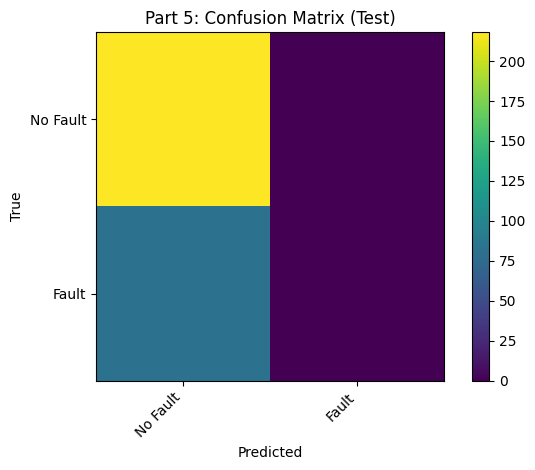

In [94]:
CLASS_NAMES_5 = ["No Fault", "Fault"]

pred_train = predict_part5(model5, X_train_s5)
pred_test  = predict_part5(model5, X_test_s5)

print('\n=== Part 5 | Train ===')
print(classification_report(y_train5, pred_train, target_names=CLASS_NAMES_5, digits=4))
cm_tr = confusion_matrix(y_train5, pred_train, labels=[0, 1])
plot_cm(cm_tr, 'Part 5: Confusion Matrix (Train)', CLASS_NAMES_5)

print('\n=== Part 5 | Test ===')
print(classification_report(y_test5, pred_test, target_names=CLASS_NAMES_5, digits=4))
cm_te = confusion_matrix(y_test5, pred_test, labels=[0, 1])
plot_cm(cm_te, 'Part 5: Confusion Matrix (Test)', CLASS_NAMES_5)

In [83]:
pred_test = predict_part5(model5, X_test_s5)
print("Predicted class counts:", np.bincount(pred_test))   # how many 0 vs 1 predicted?
print("True class counts:", np.bincount(y_test5))          # how many 0 vs 1 actually?

Predicted class counts: [300]
True class counts: [218  82]
